In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '45_19ft'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y_ce(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.875)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

In [17]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y_ce(y_img[:,:,0])

In [18]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

## U-net (ish)

In [21]:
from torchvision.models import vgg11_bn

In [22]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [23]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [24]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [25]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [26]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [27]:
class Unet34(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,out,16)
        self.up6 = nn.ConvTranspose2d(16, out, 1)
        
    def forward(self,x):
        inp = x
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [28]:
class Unet34Mod(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,16,16)
        self.up6 = nn.ConvTranspose2d(16, out, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(out,16,1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [ ]:
class Unet34Mod2(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5 = UnetBlock(64,32,32)
        self.up6 = nn.ConvTranspose2d(32, out, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(out,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
        return lgs + [children(model)[1:]]

In [30]:
def carce_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,:,:]==1, beta=2)

In [31]:
def rdce_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,:,:]==2, beta=0.5)
    return f

In [32]:
def carsig_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(p2[:,0,:,:], targs[:,0,:,:], beta=2, threshold=0.5)

In [33]:
def rdsig_f(pred, targs):
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(p2[:,1,:,:], targs[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [34]:
def car_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,1,:,:], beta=2)

In [35]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,2,:,:], beta=0.5)
    return f

In [36]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [37]:
def new_acc_sig(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()

In [38]:
def new_acc_ce(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()

In [39]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
    return (idx == t_idx).float().mean()

In [81]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, softmax=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [82]:
def get_learner(md, m_fn=Unet34Mod, weights=[1,200,2], half=False, softmax=True, dice=False):
    out_sz = 3 if softmax else 2
    m = to_gpu(m_fn(out_sz))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor(weights)
    if half:
        class_weights = class_weights.half()
        learn.half()
        
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.metrics = [new_acc_ce, rdce_f, carce_f_p_r]
    
    
    learn.crit=SoftDiceLoss(weight=class_weights, softmax=softmax)
#     if softmax: learn.metrics=[new_acc, rd_f, car_f_p_r]
#     else: learn.metrics = [new_acc_sig, rdsig_f, carsig_f_p_r]
    return learn

### Models

In [83]:
ext = '-300'
sz=192
bs=64
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [84]:
learn = get_learner(md, m_fn=Unet34, weights=[1,10,2], softmax=True)
learn.load(f'600urn-19-weights')

 85%|████████▌ | 145/170 [00:24<00:04,  5.96it/s, loss=0.63] 

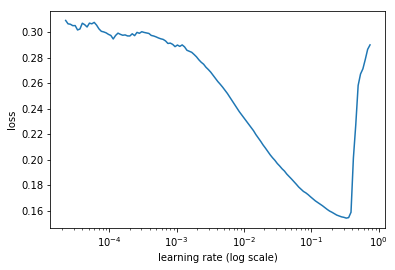

In [60]:
learn.lr_find()
learn.sched.plot()

In [85]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [86]:
learn.unfreeze()

In [87]:
learn.fit(lrs, 1, wds=wd, cycle_len=2,use_clr=(20,10))

 13%|█▎        | 22/170 [00:05<00:37,  3.96it/s, loss=0.986]

Process Process-130:
Process Process-131:
Process Process-133:
Process Process-129:
Process Process-127:
Process Process-128:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-132:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 5

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 118, in __call__
    return F.normalize(tensor, self.mean, self.std)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 425, in adjust_contrast
    enhancer = ImageEnhance.Contrast(img)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/ImageEnhance.py", line 66, in __init__
    mean = int(ImageStat.Stat(image.convert("L")).mean[0] + 0.5)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 160, in normalize
    for t, m, s in zip(tensor, mean, std):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Im

Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-31709630340d>", line 1, in <module>
    learn.fit(lrs, 1, wds=wd, cycle_len=2,use_clr=(20,10))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 139, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 54, in step
    loss = raw_loss = self.crit(output, y)
  File "

KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/tensor.py", line 361, in <lambda>
    return iter(imap(lambda i: self[i], range(self.size(0))))
KeyboardInterrupt


### Diff weights

In [67]:
learn = get_learner(md, m_fn=Unet34, weights=[1,1000,2], softmax=True)
learn.load(f'600urn-19-weights')

learn.unfreeze()

learn.fit(lrs, 1, wds=wd, cycle_len=3,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.585691   0.430237   0.982815   0.990479   0.863085   0.726227   0.907799  
    1      0.507419   0.352849   0.981836   0.990482   0.86298    0.685963   0.924875  
    2      0.441042   0.359947   0.981674   0.99042    0.863402   0.690874   0.923274  


[0.3599466514587402,
 0.981674427986145,
 0.9904195880889892,
 0.8634018087387085,
 0.6908737778663635,
 0.9232737779617309]

In [ ]:
learn = get_learner(md, m_fn=Unet34, weights=[1/1000,1,1/50], softmax=True)
learn.load(f'600urn-19-weights')

learn.unfreeze()

learn.fit(lrs, 1, wds=wd, cycle_len=2,use_clr=(20,10))

In [ ]:
learn = get_learner(md, m_fn=Unet34, weights=[1,1000,2], softmax=True)
learn.load(f'600urn-19-weights')

learn.unfreeze()

learn.fit(lrs, 1, wds=wd, cycle_len=2,use_clr=(20,10))

### 512

In [57]:
ext = ''
sz=320
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [58]:
learn = get_learner(md, m_fn=Unet34, weights=[1,4,2], softmax=True)
learn.load(f'600urn-19-weights')

In [59]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [60]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [61]:
learn.fit(lrs, 1, wds=wd, cycle_len=1,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.066339   0.063312   0.986369   0.989354   0.831383   0.687918   0.882404  



[0.06331216678023338,
 0.9863685894012452,
 0.9893538594245911,
 0.8313831675052643,
 0.6879177880287171,
 0.8824036765098572]

In [62]:
learn.fit(lrs/20, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.06418    0.063924   0.986295   0.989288   0.832011   0.681567   0.886217  
    1      0.062894   0.063157   0.98638    0.989386   0.833749   0.680557   0.889093  
    2      0.062201   0.062188   0.986423   0.989399   0.833299   0.683626   0.886873  



[0.06218768492341042,
 0.9864228820800781,
 0.989399163722992,
 0.8332987737655639,
 0.6836258298158646,
 0.8868733263015747]

In [63]:
learn.save(f'600urn-{S_PREFIX}-w4-320')

### Try 2

In [43]:
ext = ''
sz=320
bs=24
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [44]:
learn = get_learner(md, m_fn=Unet34, weights=[1,25,2], softmax=True)
learn.load(f'600urn-19-weights')

In [45]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [46]:
learn.unfreeze()

In [47]:
learn.fit(lrs, 1, wds=wd, cycle_len=1,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.083335   0.081102   0.978033   0.989201   0.783248   0.489305   0.957276  



[0.08110182389616966,
 0.9780332469940185,
 0.9892006802558899,
 0.7832478368282318,
 0.48930494338274,
 0.9572764658927917]

In [ ]:
learn.save(f'600urn-{S_PREFIX}-w25')

### Loader

In [49]:
ext = ''
sz=384
bs=24
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [50]:
learn = get_learner(md, m_fn=Unet34, weights=[1,4,2], softmax=True)
learn.load(f'600urn-19-weights')

In [51]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [52]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [53]:
learn.fit(lrs, 1, wds=wd, cycle_len=1,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.086951   0.048171   0.988757   0.990054   0.865028   0.776669   0.892201  



[0.04817071918398142,
 0.9887566232681274,
 0.9900537562370301,
 0.8650275468826294,
 0.7766694796085357,
 0.892201099395752]

In [55]:
learn.fit(lrs, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.063598   0.047333   0.988861   0.990619   0.868936   0.757252   0.90496   
    1      0.05666    0.045767   0.989742   0.992007   0.875719   0.796291   0.899614  
    2      0.054229   0.047209   0.9898     0.991072   0.872787   0.802669   0.893699  



[0.04720917873084545,
 0.9897998213768006,
 0.9910722017288208,
 0.8727874612808227,
 0.8026689505577087,
 0.8936987066268921]

In [56]:
learn.save(f'600urn-{S_PREFIX}-w4-384')

### Loader 2

In [42]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [43]:
learn = get_learner(md, m_fn=Unet34, weights=[1,4,2], softmax=True)
learn.load(f'600urn-{S_PREFIX}-w4-384')

In [44]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [45]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [46]:
learn.fit(lrs, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.020713   0.036598   0.990462   0.992489   0.880022   0.800293   0.90361   
    1      0.01745    0.03544    0.990664   0.992643   0.88513    0.800949   0.910265  
    2      0.016676   0.034573   0.990947   0.992732   0.88495    0.807818   0.907696  



[0.03457291729748249,
 0.9909473490715027,
 0.9927318120002746,
 0.8849498629570007,
 0.8078181207180023,
 0.9076959681510925]

In [47]:
learn.save(f'600urn-{S_PREFIX}-w4-384-nocrop')

### Loader

In [48]:
ext = ''
sz=384
bs=24
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [49]:
learn = get_learner(md, m_fn=Unet34, weights=[1,4,2], softmax=True)
learn.load(f'600urn-{S_PREFIX}-w4-384-nocrop')

In [52]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])

In [53]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [54]:
learn.fit(lrs, 1, wds=wd, cycle_len=2,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.057076   0.04296    0.989948   0.991177   0.87945    0.800968   0.903084  
    1      0.053725   0.043992   0.989946   0.991651   0.881595   0.792273   0.909094  



[0.04399244755506516,
 0.9899460458755494,
 0.9916511750221253,
 0.881594581604004,
 0.7922728323936462,
 0.9090940356254578]

### Back to crop

In [56]:
ext = ''
sz=384
bs=24
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [57]:
learn = get_learner(md, m_fn=Unet34, weights=[1,4,2], softmax=True)
learn.load(f'600urn-{S_PREFIX}-w4-384-nocrop')

In [58]:
learn.fit(lrs/20, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.015198   0.034632   0.990812   0.992898   0.885754   0.798041   0.912007  
    1      0.015293   0.034699   0.990916   0.99267    0.884624   0.80851    0.907058  
    2      0.01533    0.03449    0.990868   0.992601   0.8852     0.80398    0.909299  



[0.034490275271236895,
 0.9908682608604431,
 0.9926014685630798,
 0.8852004361152649,
 0.8039799547195434,
 0.9092989134788513]

In [ ]:
learn.save(f'600urn-{S_PREFIX}-w4-384-nocrop-2')

In [60]:
a = torch.ones([3,5,6])

In [61]:
a.shape

torch.Size([3, 5, 6])

In [62]:
b = a.unsqueeze(1)

In [64]:
torch.cat((b,b), dim=1).shape

torch.Size([3, 2, 5, 6])